### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Install

In [ ]:
pip install tensorboardX

     |████████████████████████████████| 317kB 8.3MB/s 


In [ ]:
pip install staintools

  Created wheel for staintools: filename=staintools-2.1.2-cp36-none-any.whl size=14070 sha256=ad97023f67d9198ab28a4e60433608b91bd4399d2d6e652e84ac09d19afcd7b7
  Stored in directory: /root/.cache/pip/wheels/76/01/f8/81c62c374358f5baf8b278b5c57ab13534eb8f811bff1ddcb8
Successfully built staintools


In [ ]:
pip install spams

     |████████████████████████████████| 1.9MB 8.4MB/s 
  Created wheel for spams: filename=spams-2.6.1-cp36-cp36m-linux_x86_64.whl size=4512933 sha256=3d1bb14f005c579602fe1df8cc86ba3a484af7c370ca56c5eb0dcb1767018309
  Stored in directory: /root/.cache/pip/wheels/76/a6/a8/5959872693a82d5497a91aee3665bb1676cee33304d86c1495
Successfully built spams


### Clean data functions

In [ ]:
#Rename files

def rename_4x20x_files(path):

  files = os.listdir(path)

  for index, f in enumerate(files):
      new_name = f.split('-')
      new_name[0] += '20x'
      new_name = '-'.join(new_name)
      os.rename(os.path.join(path, f), os.path.join(path, new_name))

def rename_20x100x_files(path):

  files = os.listdir(path)

  for index, f in enumerate(files):
      new_name = f.split('_')
      new_name.pop(1)
      new_name = '_'.join(new_name)
      os.rename(os.path.join(path, f), os.path.join(path, new_name))

In [ ]:
def remove_duplicate(path):

  files = os.listdir(path)
  deleted_files = []

  for index, f in enumerate(files):
    test_split = f.split(' (1).')
    if len(test_split) > 1:
      deleted_files.append(f)
      os.remove(os.path.join(path, f))
  
  return deleted_files

### Libraries

In [ ]:
from google.colab import files
from PIL import Image
from distutils.dir_util import copy_tree
from tqdm import tqdm 
from skimage.io import imread, imshow
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from numpy import loadtxt

import os
import random
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import shutil

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.layers import MSELossFlat
from fastai.metrics import mean_squared_error

from torchvision.models import vgg16_bn

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
#For LAMB optimizer

import collections
import math

import torch
from tensorboardX import SummaryWriter
from torch.optim import Optimizer

In [ ]:
#For Staintools

import staintools
import spams
import cv2 as cv

from staintools.stain_extraction.abc_stain_extractor import ABCStainExtractor
from staintools.tissue_masks.luminosity_threshold_tissue_locator import LuminosityThresholdTissueLocator
from staintools.preprocessing.input_validation import is_uint8_image

In [ ]:
#For DA

from fastai.torch_core import *
from fastai.callback import *
from fastai.train import mixup
from fastai.callbacks.mixup import MixUpCallback, MixUpLoss
from fastai.basic_train import Learner, LearnerCallback
from fastai.vision.image import Image, TfmPixel
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
#For Masks

import matplotlib.pyplot as plt

from skimage import color
from skimage import morphology
from skimage import segmentation

### Reproducibility

In [ ]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
#Set it at 12 for reproducibility

set_seed(12)

### LAMB Optimizer

In [ ]:
#Credits to https://github.com/mgrankin/over9000

def log_lamb_rs(optimizer: Optimizer, event_writer: SummaryWriter, token_count: int):
    """Log a histogram of trust ratio scalars in across layers."""
    results = collections.defaultdict(list)
    for group in optimizer.param_groups:
        for p in group['params']:
            state = optimizer.state[p]
            for i in ('weight_norm', 'adam_norm', 'trust_ratio'):
                if i in state:
                    results[i].append(state[i])

    for k, v in results.items():
        event_writer.add_histogram(f'lamb/{k}', torch.tensor(v), token_count)

class Lamb(Optimizer):
    r"""Implements Lamb algorithm.
    It has been proposed in `Large Batch Optimization for Deep Learning: Training BERT in 76 minutes`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        adam (bool, optional): always use trust ratio = 1, which turns this into
            Adam. Useful for comparison purposes.
    .. _Large Batch Optimization for Deep Learning: Training BERT in 76 minutes:
        https://arxiv.org/abs/1904.00962
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6,
                 weight_decay=0, adam=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Paper v3 does not use debiasing.
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr'] # * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(group['weight_decay'], p.data)

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(-step_size * trust_ratio, adam_step)

        return loss

### Load & Prepare Data

In [ ]:
#Tile 100

IMG_WIDTH = 2160//10 #216
IMG_HEIGHT = 2560//10 #256
IMG_CHANNELS = 3

batch_size = 16

size = (IMG_WIDTH,IMG_HEIGHT)

In [ ]:
arch = models.resnet34
wd = 1e-3

In [ ]:
TRAIN_PATH = pathlib.Path('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/')
TEST_PATH = pathlib.Path('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/test/')

In [ ]:
TRAIN_PATH.ls()

[PosixPath('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/high_res2'),
 PosixPath('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/low_res'),
 PosixPath('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/high_res'),
 PosixPath('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/image_gen'),
 PosixPath('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/models')]

In [ ]:
TRAIN_X = TRAIN_PATH/'low_res'
TRAIN_Y = TRAIN_PATH/'high_res'

In [ ]:
TEST_X = TEST_PATH/'low_res'
TEST_Y = TEST_PATH/'high_res'

In [ ]:
src = ImageImageList.from_folder(TRAIN_X).split_by_rand_pct(0.1)
src

ItemLists;

Train: ImageImageList (1980 items)
Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256)
Path: /content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/low_res;

Valid: ImageImageList (220 items)
Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256)
Path: /content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train/low_res;

Test: None

In [ ]:
#Define transforms

tfms = get_transforms(
               do_flip=True,
               flip_vert=True,
               max_rotate=25.0,
               max_zoom=1,
               max_lighting=0.2,
               max_warp=0,
               p_affine=0.4,
               p_lighting=0.4,
               xtra_tfms=None)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: TRAIN_Y/x.name)
           .transform(tfms=tfms, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(batch_size,(IMG_WIDTH,IMG_HEIGHT))

In [ ]:
#data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

### Staintools

In [ ]:
def get_sign(x):
    """
    Returns the sign of x.
    :param x: A scalar x.
    :return: The sign of x.
    """

    if x > 0:
        return +1
    elif x < 0:
        return -1
    elif x == 0:
        return 0


def normalize_matrix_rows(A):
    """
    Normalize the rows of an array.
    :param A: An array.
    :return: Array with rows normalized.
    """
    return A / np.linalg.norm(A, axis=1)[:, None]

def convert_RGB_to_OD(I):
    """
    Convert from RGB to optical density (OD_RGB) space.
    RGB = 255 * exp(-1*OD_RGB).
    :param I: Image RGB uint8.
    :return: Optical denisty RGB image.
    """
    mask = (I == 0)
    I[mask] = 1
    return np.maximum(-1 * np.log(I / 255), 1e-6)


def convert_OD_to_RGB(OD):
    """
    Convert from optical density (OD_RGB) to RGB.
    RGB = 255 * exp(-1*OD_RGB)
    :param OD: Optical denisty RGB image.
    :return: Image RGB uint8.
    """
    assert OD.min() >= 0, "Negative optical density."
    OD = np.maximum(OD, 1e-6)
    return (255 * np.exp(-1 * OD)).astype(np.uint8)    

def convert_Image_RGB(x):

  return (x.data*255).permute(1,2,0).cpu().numpy().astype(np.uint8) #CAREFUL

def convert_RGB_Image(x):

  return torch.Tensor((x/255)).permute(2,0,1)

In [ ]:
#With mean values

def transform_normalize(img, maxC_target, S_mean):
    """
    Transform an image.
    :param I: Image
    :return:
    """
    I = convert_Image_RGB(img)

    S = get_stain_matrix(I)
    C = get_concentrations(I, S)
    maxC_source = np.percentile(C, 99, axis=0).reshape((1, 2))
    C *= (maxC_target / maxC_source)
    tmp = 255 * np.exp(-1 * np.dot(C, S_mean))

    return convert_RGB_Image(tmp.reshape(I.shape).astype(np.uint8))

In [ ]:
#One to one 

def transform_normalize_one2one(img_source, img_target):
    """
    Transform an image.
    :param img1: Image source
    :param img1: Image source
    :return:
    """
    I_s = convert_Image_RGB(img_source)
    I_t = convert_Image_RGB(img_target)

    S_s = get_stain_matrix(I_s)
    C_s = get_concentrations(I_s, S_s)

    S_t = get_stain_matrix(I_t)
    C_t = get_concentrations(I_t, S_t)

    #maxC_target = np.percentile(C_t, 99, axis=0).reshape((1, 2))
    #maxC_source = np.percentile(C_s, 99, axis=0).reshape((1, 2))

    #C_s *= (maxC_target / maxC_source)

    tmp = 255 * np.exp(-1 * np.dot(C_s, S_t))

    return convert_RGB_Image(tmp.reshape(I_s.shape).astype(np.uint8))

In [ ]:
def get_stain_matrix(I, luminosity_threshold=0.8, regularizer=0.1):
        """
        Stain matrix estimation via method of:
        A. Vahadane et al. 'Structure-Preserving Color Normalization and Sparse Stain Separation for Histological Images'
        :param I: Image RGB uint8.
        :param luminosity_threshold:
        :param regularizer:
        :return:
        """
        assert is_uint8_image(I), "Image should be RGB uint8."
        # convert to OD and ignore background
        tissue_mask = LuminosityThresholdTissueLocator.get_tissue_mask(I, luminosity_threshold=luminosity_threshold).reshape((-1,))
        OD = convert_RGB_to_OD(I).reshape((-1, 3))
        OD = OD[tissue_mask]

        # do the dictionary learning
        dictionary = spams.trainDL(X=OD.T, K=2, lambda1=regularizer, mode=2,
                                   modeD=0, posAlpha=True, posD=True, verbose=False).T

        # order H and E.
        # H on first row.
        if dictionary[0, 0] < dictionary[1, 0]:
            dictionary = dictionary[[1, 0], :]

        return normalize_matrix_rows(dictionary)

def get_tissue_mask(I, luminosity_threshold=0.8):
        """
        Get a binary mask where true denotes pixels with a luminosity less than the specified threshold.
        Typically we use to identify tissue in the image and exclude the bright white background.
        :param I: RGB uint 8 image.
        :param luminosity_threshold: Luminosity threshold.
        :return: Binary mask.
        """
        assert is_uint8_image(I), "Image should be RGB uint8."
        I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
        L = I_LAB[:, :, 0] / 255.0  # Convert to range [0,1].
        mask = L < luminosity_threshold

        # Check it's not empty
        if mask.sum() == 0:
            raise TissueMaskException("Empty tissue mask computed")

        return mask

def standardize(I, percentile=95):
        """
        Transform image I to standard brightness.
        Modifies the luminosity channel such that a fixed percentile is saturated.
        :param I: Image uint8 RGB.
        :param percentile: Percentile for luminosity saturation. At least (100 - percentile)% of pixels should be fully luminous (white).
        :return: Image uint8 RGB with standardized brightness.
        """
        assert is_uint8_image(I), "Image should be RGB uint8."
        I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
        L_float = I_LAB[:, :, 0].astype(float)
        p = np.percentile(L_float, percentile)
        I_LAB[:, :, 0] = np.clip(255 * L_float / p, 0, 255).astype(np.uint8)
        I = cv.cvtColor(I_LAB, cv.COLOR_LAB2RGB)
        return I

def get_concentrations(I, stain_matrix, regularizer=0.01):
        """
        Estimate concentration matrix given an image and stain matrix.
        :param I:
        :param stain_matrix:
        :param regularizer:
        :return:
        """
        OD = convert_RGB_to_OD(I).reshape((-1, 3))
        return spams.lasso(X=OD.T, D=stain_matrix.T, mode=2, lambda1=regularizer, pos=True).toarray().T

In [ ]:
def decompose_image(x):

    I = convert_Image_RGB(x)
    I = staintools.LuminosityStandardizer.standardize(I)

    S = get_stain_matrix(I)
    C = get_concentrations(I,S)

    return S , C

def col_deconvolution(x,axis=0):
  
  concentration = decompose_image(x)[1][:,axis].reshape(55296,1)
  color = decompose_image(x)[0][axis].reshape(1,3)

  OD_flat = np.dot(concentration,color)
  I = 255 * np.exp(-OD_flat) #From Beer-Lambert Law
  I = I.reshape(216,256,3)
  img = convert_RGB_Image(I)

  return img

In [ ]:
def mask(img,lum_thresh=0.81):

  #Convert to RGB
  img = convert_Image_RGB(img)
  img = staintools.LuminosityStandardizer.standardize(img, 95)

  # Compute a mask
  lum = color.rgb2gray(img)
  mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < lum_thresh, 150),
    750)
  
  mask = morphology.binary_closing(mask, morphology.disk(8))

  return PIL.Image.fromarray(mask)

In [ ]:
def single_out_cells(img):

  img_mask = np.array(mask(img)) #needs array, not PIL Image
  tensor_mask = torch.unsqueeze(torch.Tensor(img_mask) / 255, 2) #For broadcasting

  img_masked = tensor_mask * torch.Tensor(convert_Image_RGB(img))

  return Image(convert_RGB_Image(img_masked)) 

In [ ]:
def apply_mask(img, mask):

  tensor_mask = torch.unsqueeze(torch.Tensor(mask) / 255, 2) #For broadcasting
  img_masked = tensor_mask * torch.Tensor(convert_Image_RGB(img))

  return Image(convert_RGB_Image(img_masked)) 

In [ ]:
def flip_mask(msk):

  ar = np.array(msk)

  return PIL.Image.fromarray(~ar)

In [ ]:
def convert(x, val):

  if x == 0:
    return val
  else:
    return x

vecfunc = np.vectorize(convert)    

In [ ]:
def pseudo_mask(img, val):

  mask_value = torch.Tensor(np.array(mask(img)))
  pseudo_mask = vecfunc(mask_value, val)
  applied_pseudo_mask = apply_mask(img,pseudo_mask)

  return applied_pseudo_mask

In [ ]:
def tensor_pseudo_mask(tns,val):

  #pseudo_masked_tns = torch.empty(tns.shape, requires_grad = True)
  #pseudo_masked_tns1 = pseudo_masked_tns.clone()

  for i in range(len(tns)):

    tns[i,:,:,:] = pseudo_mask(tns[i,:,:,:],val).data

  return tns.cuda()

In [ ]:
def mask_tensor(target, val):

  mask_tns = torch.empty(target.shape)

  for i in range(len(target)):

    mask_tns[i,:,:,:] = torch.unsqueeze(torch.Tensor(np.array(mask(target[i,:,:,:]))) / 255, 2).permute(2,0,1)

  return torch.Tensor(vecfunc(mask_tns,val)).cuda()

In [ ]:
S_mean = [[0.641191, 0.586393, 0.45957 ],[0.447447, 0.59187 , 0.641535]]
C_mean = np.loadtxt('/content/drive/My Drive/Dissertation/c_mean.csv',delimiter = ',')

### Feature Loss

In [ ]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
gram_matrix(t)

tensor([[[0.2406, 0.2315, 0.2314],
         [0.2315, 0.2232, 0.2229],
         [0.2314, 0.2229, 0.2227]],

        [[0.2406, 0.2315, 0.2314],
         [0.2315, 0.2232, 0.2229],
         [0.2314, 0.2229, 0.2227]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        #self.feat_losses = [base_loss(input,target)]

        loss = abs(input - target) 
        mask_loss = mask_tensor(target,0.01) 
        loss = mask_loss.cuda() * loss.cuda() 
        self.feat_losses = [loss.sum() / input.data.nelement()] 

        self.feat_losses += [0.01 * base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [0.01 * base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Training 'Classic'

In [ ]:
learn_test = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight, 
                     opt_func=Lamb)

gc.collect();

In [ ]:
class _Loss(Module):
    reduction: str

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class _WeightedLoss(_Loss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_WeightedLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)


In [ ]:
class MAE_Mask_Loss(_Loss):

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(MAE_Mask_Loss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:

        loss = abs(input - target)
        mask_loss = mask_tensor(target,0)
        loss = mask_loss.cuda() * loss.cuda()

        return loss.sum() / input.data.nelement()

In [ ]:
learner_mask = None;

learner_mask = unet_learner(data, arch, wd=wd, loss_func=MAE_Mask_Loss(reduction='mean'),
                     blur=True, norm_type=NormType.Weight, 
                     opt_func=Lamb)

gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 2.51E-04


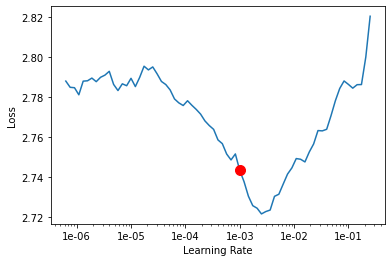

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#lr = learn.recorder.min_grad_lr
lr = 1e-4

In [ ]:
def do_fit(learn, epochs, save_name, lrs=slice(lr), pct_start=0.90,show_results=False):

    callbacks = [ShowGraph(learn),
             SaveModelCallback(learn,mode='min',name='/content/best_model')
             ,ReduceLROnPlateauCallback(learn, mode='min', patience=3, factor=0.2, min_lr=1e-7)
             ]

    learn.fit_one_cycle(epochs, max_lr=lrs, pct_start=pct_start, callbacks=callbacks)
    learn.recorder.plot_lr(show_moms=True) #Optional
    learn.save(save_name, with_opt=True)
    if show_results:
      learn.show_results(rows=1, imgsize=5)

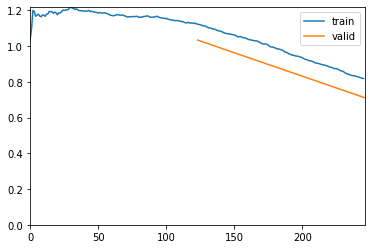

Better model found at epoch 0 with valid_loss value: 1.0344270467758179.
Better model found at epoch 1 with valid_loss value: 0.7109501361846924.


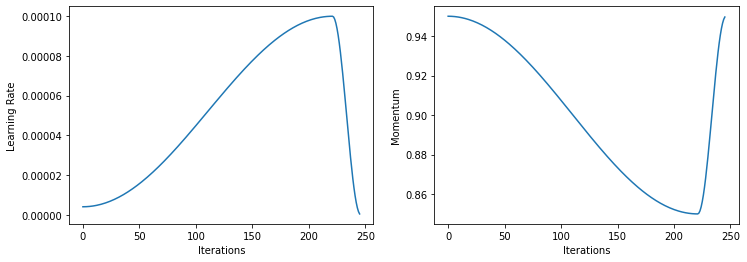

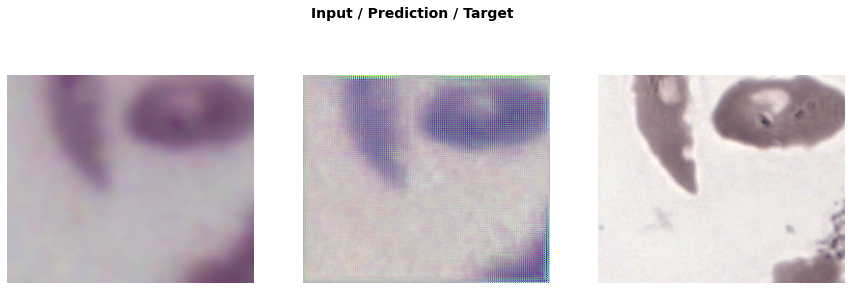

In [ ]:
do_fit(learn_test,2,'/content/20x100x_frozen', slice(1e-4),show_results=True) #(To check!)

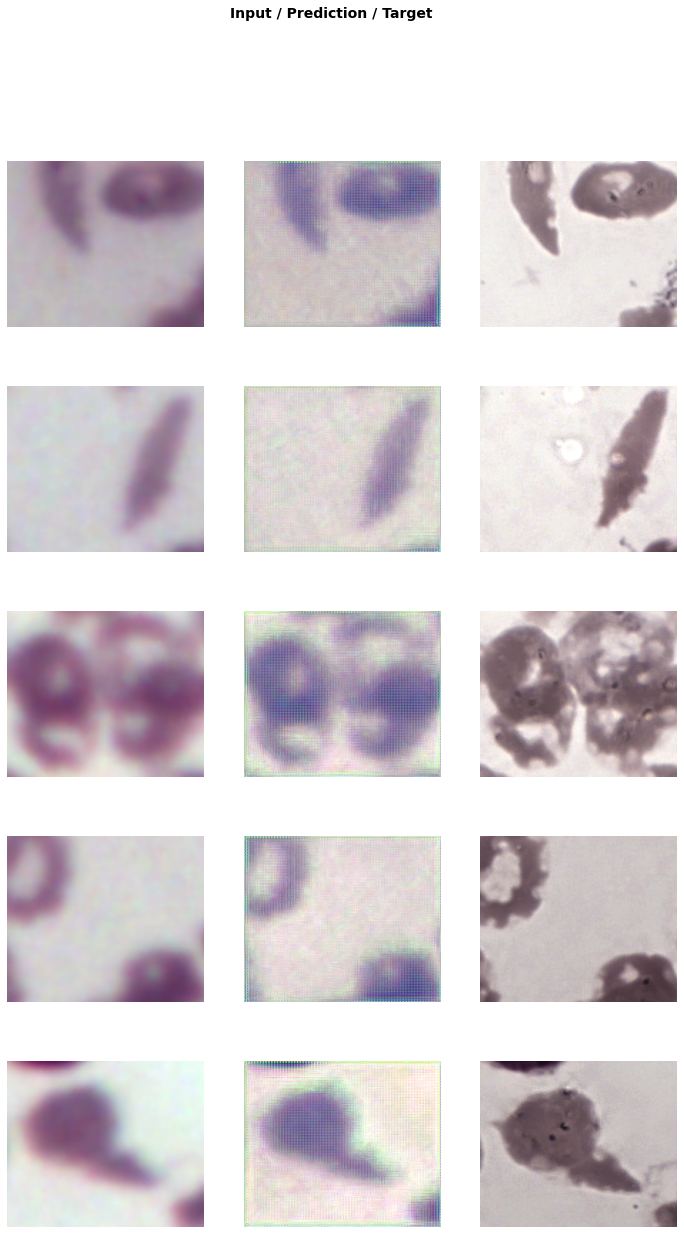

In [ ]:
learn_test.show_results()

In [ ]:
learn_test.load('/content/best_model')
learn_test.unfreeze()

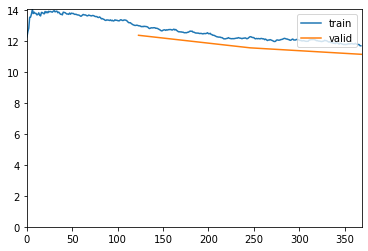

Better model found at epoch 0 with valid_loss value: 12.386799812316895.
Better model found at epoch 1 with valid_loss value: 11.575648307800293.
Better model found at epoch 2 with valid_loss value: 11.155375480651855.


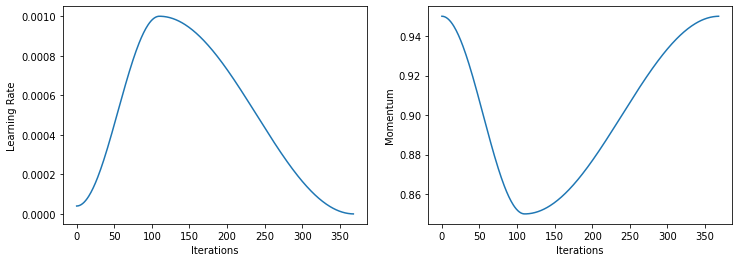

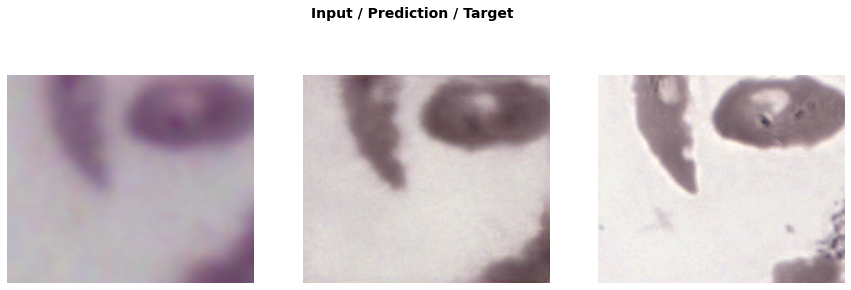

In [ ]:
do_fit(learn_test,3,'/content/20x100x_final', slice(1e-5,lr), pct_start=0.3, show_results=True)

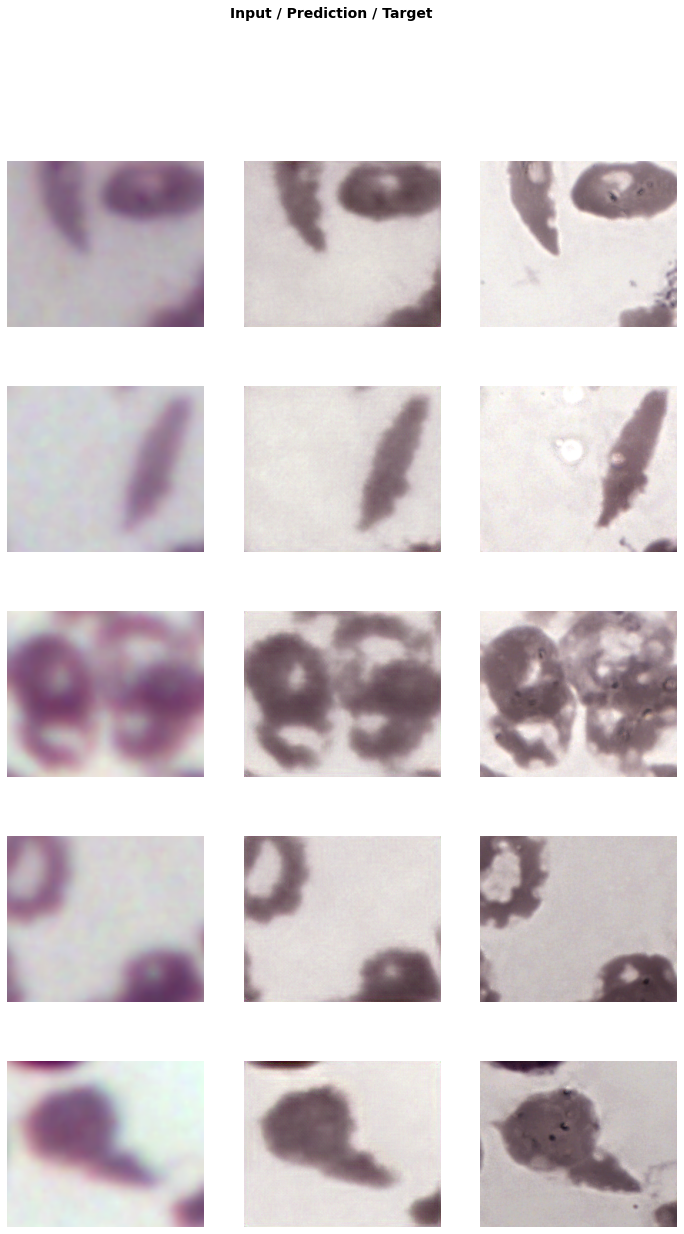

In [ ]:
learn_test.show_results(rows=5)

In [ ]:
learn_test.export('/content/export_20_001')

### Alternative DA

#### CutOut

In [ ]:
new_tfms = (tfms[0] + [cutout(n_holes=(1,3), length=(20, 60), p=.8, use_on_y=False)], tfms[1])

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: TRAIN_Y/x.name)
           .transform(tfms=new_tfms, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(batch_size,(IMG_WIDTH,IMG_HEIGHT))

#### MixUp

In [ ]:
class MixUpTestCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=False):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)] #Changed here
            new_target = (last_target * lambd.view(out_shape) + y1 * (1-lambd).view(out_shape)) #Changed here
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = loss1 * target[:,2] + loss2 * (1-target[:,2])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

#### CutBlur

In [ ]:
#Credits to https://github.com/oguiza/fastai_extensions

class CutBlurCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y,self.true_λ = alpha,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutblur to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)

        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = y1[..., bby1:bby2, bbx1:bbx2]

        new_target = last_target.clone()
        new_target[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]

        λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])
        
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutblur(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add cutblur https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutBlurCallback, alpha=alpha, stack_y=stack_y, true_λ=true_λ))
    return learn

setattr(cutblur, 'cb_fn', CutBlurCallback)
Learner.cutblur = cutblur


def get_x1_coords(x_size, n_patches, same_size=True):
    if same_size:
        w = np.linspace(0, x_size[-1], num=n_patches[0] + 1).astype(np.int64)
        h = np.linspace(0, x_size[-2], num=n_patches[1] + 1).astype(np.int64)
    else:
        w, h = [], []
        if n_patches[0] > 1:
            w = sorted(list(np.random.choice(np.arange(0, x_size[-1]),
                                             size= n_patches[0] - 1, replace=False)))
        if n_patches[1] > 1:
            h = sorted(list(np.random.choice(np.arange(0, x_size[-2]),
                                             size= n_patches[1] - 1, replace=False)))
        w = [0] + w + [x_size[-1]]
        h = [0] + h + [x_size[-2]]
    patch = []
    for i in range(n_patches[0]):
        for j in range(n_patches[1]):
            patch.append([h[j], h[j + 1], w[i], w[i + 1]])
    return patch


def get_x1_rand_coords(x_size, n_patches, w, h, same_size=True):
    if not same_size:
        a = w * h
        p = np.random.uniform() + .5
        w = max(1, int(p * w))
        h = max(1, int(a / w))
    w_x = np.random.randint(0, x_size[-1]) if n_patches[0] != 1 else 0
    w_xa = np.clip(w_x - w // 2, 0, x_size[-1])
    w_xb = np.clip(w_x + w // 2, 0, x_size[-1])
    h_x = np.random.randint(0, x_size[-2]) if n_patches[1] != 1 else 0
    h_xa = np.clip(h_x - h // 2, 0, x_size[-2])
    h_xb = np.clip(h_x + h // 2, 0, x_size[-2])
    return h_xa, h_xb, w_xa, w_xb


def get_x2_coords(x_size, bby1, bby2, bbx1, bbx2):
    w_ = bbx2 - bbx1
    h_ = bby2 - bby1
    w_k = np.random.randint(0, x_size[-1] - w_) if w_ != x_size[-1] else 0
    h_k = np.random.randint(0, x_size[-2] - h_) if h_ != x_size[-2] else 0
    return h_k, h_k + h_, w_k, w_k + w_

#### CutMix

In [ ]:
class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y = alpha,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train or self.alpha == 0: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        #λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    if len(last_input_size) == 4:
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else: bby2 = last_input_size[1]

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix

def get_x1_coords(x_size, n_patches, same_size=True):
    if same_size:
        w = np.linspace(0, x_size[-1], num=n_patches[0] + 1).astype(np.int64)
        h = np.linspace(0, x_size[-2], num=n_patches[1] + 1).astype(np.int64)
    else:
        w, h = [], []
        if n_patches[0] > 1:
            w = sorted(list(np.random.choice(np.arange(0, x_size[-1]),
                                             size= n_patches[0] - 1, replace=False)))
        if n_patches[1] > 1:
            h = sorted(list(np.random.choice(np.arange(0, x_size[-2]),
                                             size= n_patches[1] - 1, replace=False)))
        w = [0] + w + [x_size[-1]]
        h = [0] + h + [x_size[-2]]
    patch = []
    for i in range(n_patches[0]):
        for j in range(n_patches[1]):
            patch.append([h[j], h[j + 1], w[i], w[i + 1]])
    return patch


def get_x1_rand_coords(x_size, n_patches, w, h, same_size=True):
    if not same_size:
        a = w * h
        p = np.random.uniform() + .5
        w = max(1, int(p * w))
        h = max(1, int(a / w))
    w_x = np.random.randint(0, x_size[-1]) if n_patches[0] != 1 else 0
    w_xa = np.clip(w_x - w // 2, 0, x_size[-1])
    w_xb = np.clip(w_x + w // 2, 0, x_size[-1])
    h_x = np.random.randint(0, x_size[-2]) if n_patches[1] != 1 else 0
    h_xa = np.clip(h_x - h // 2, 0, x_size[-2])
    h_xb = np.clip(h_x + h // 2, 0, x_size[-2])
    return h_xa, h_xb, w_xa, w_xb


def get_x2_coords(x_size, bby1, bby2, bbx1, bbx2):
    w_ = bbx2 - bbx1
    h_ = bby2 - bby1
    w_k = np.random.randint(0, x_size[-1] - w_) if w_ != x_size[-1] else 0
    h_k = np.random.randint(0, x_size[-2] - h_) if h_ != x_size[-2] else 0
    return h_k, h_k + h_, w_k, w_k + w_

#### Append DA & Check

In [ ]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight, 
                     opt_func=Lamb)

gc.collect();

In [ ]:
learn.callback_fns.append(partial(CutBlurCallback, alpha=0.7, stack_y=False))                     
testCutBlur = CutBlurCallback(learn, alpha=0.7, stack_y=False)

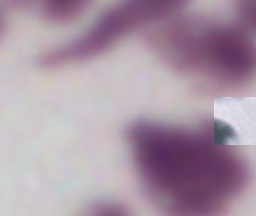

In [ ]:
Image(testCutBlur.on_batch_begin(data.x[15].data,data.y[15].data,True)['last_input'])

### Training with DA

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 2.51E-02


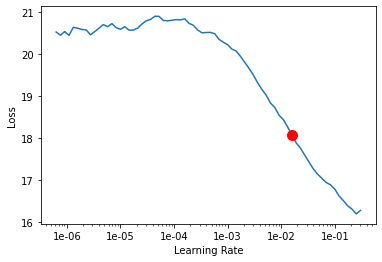

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = learn.recorder.min_grad_lr

In [ ]:
def do_fit(learn, epochs, save_name, lrs=slice(lr), pct_start=0.90,show_results=False):

    callbacks = [ShowGraph(learn),
             SaveModelCallback(learn,mode='min',name='/content/best_model')
             ,ReduceLROnPlateauCallback(learn, mode='min', patience=3, factor=0.2, min_lr=1e-7)
             ]

    learn.fit_one_cycle(epochs, max_lr=lrs, pct_start=pct_start, callbacks=callbacks)
    learn.recorder.plot_lr(show_moms=True) #Optional
    learn.save(save_name, with_opt=True)
    if show_results:
      learn.show_results(rows=1, imgsize=5)

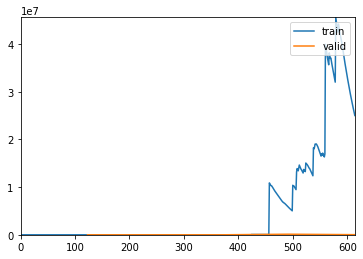

Better model found at epoch 0 with valid_loss value: 9.350461959838867.
Epoch 4: reducing lr to 1.2679145539688914e-07


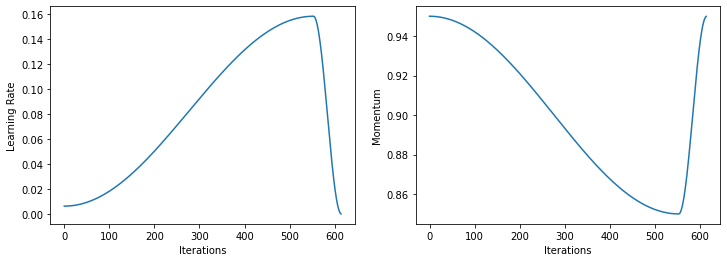

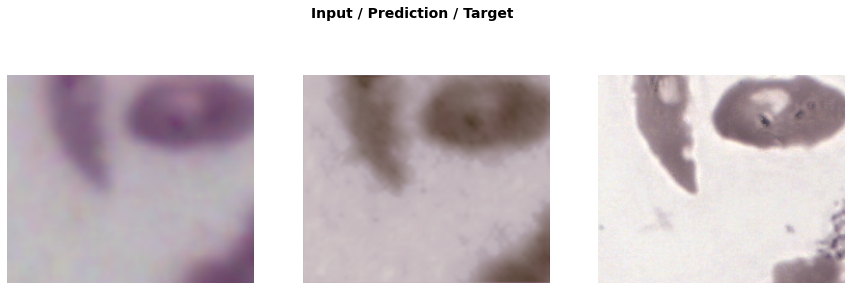

In [ ]:
do_fit(learn,5,'/content/20x100x_frozen', slice(lr*10),show_results=True) #(To check!)

In [ ]:
learn.load('/content/best_model')
learn.unfreeze()

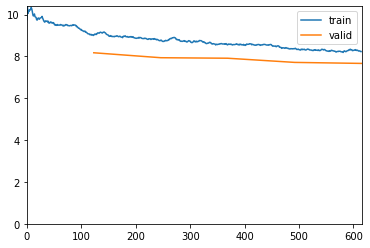

Better model found at epoch 0 with valid_loss value: 8.176514625549316.
Better model found at epoch 1 with valid_loss value: 7.939915657043457.
Better model found at epoch 2 with valid_loss value: 7.915392875671387.
Better model found at epoch 3 with valid_loss value: 7.715892791748047.
Better model found at epoch 4 with valid_loss value: 7.6678338050842285.


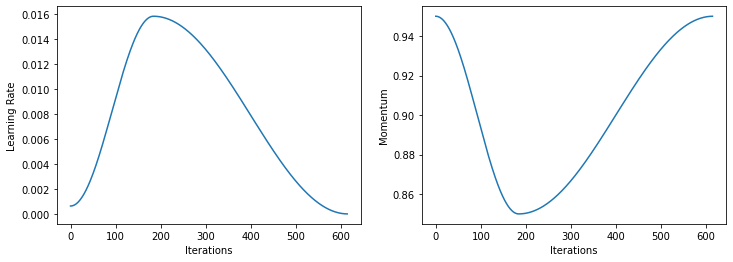

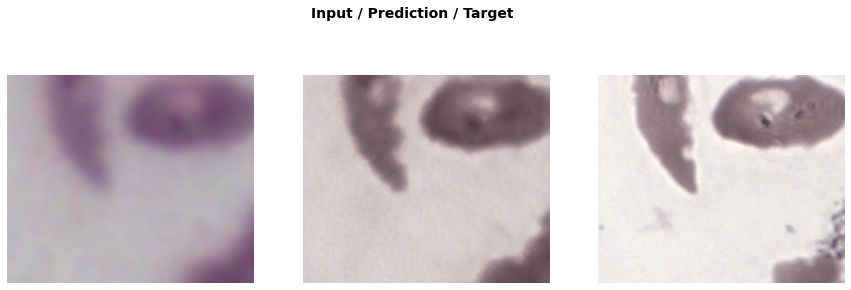

In [ ]:
do_fit(learn,5,'/content/20x100x_final_joint', slice(1e-5,lr), pct_start=0.3, show_results=True)

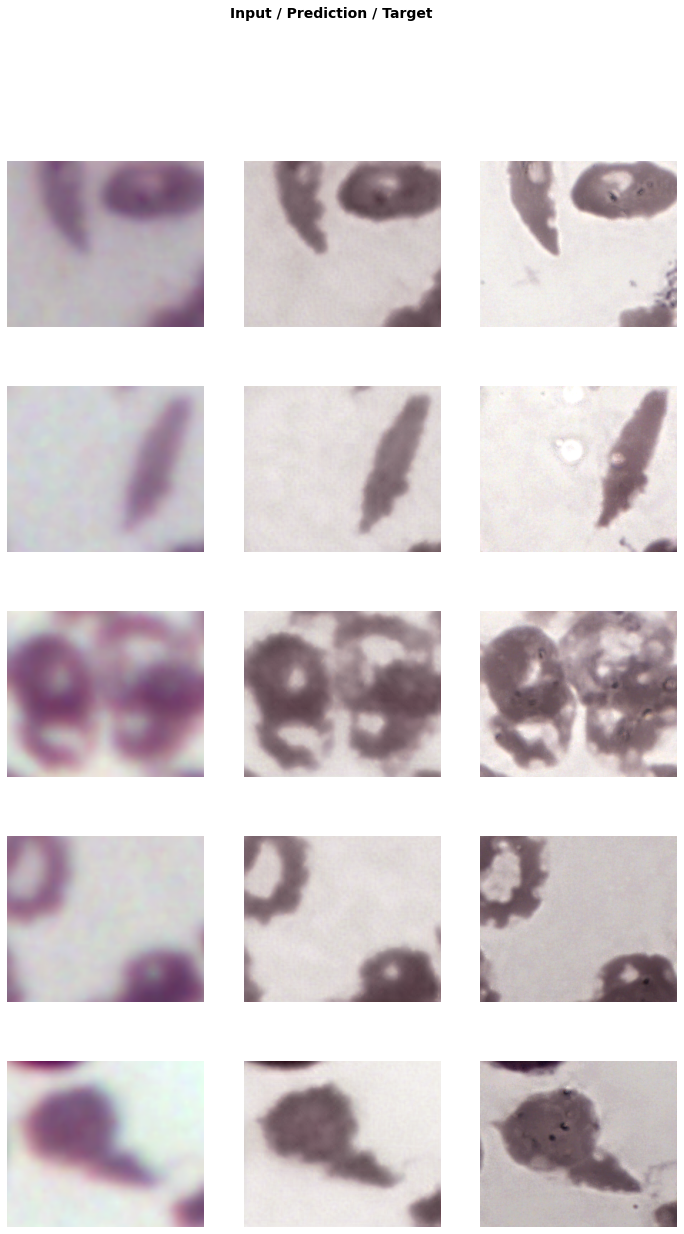

In [ ]:
learn.show_results(rows=5)

In [ ]:
learn.export('/content/export2')

### Visualize Results

In [ ]:
rdm = random.randint(0,len(learn.data.valid_ds))
rdm

781

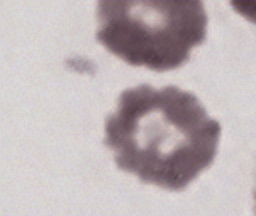

In [ ]:
this_example = learn.predict(learn.data.valid_ds[rdm][0])[0]
this_example

### Test

In [ ]:
pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-cp36-none-any.whl size=10390 sha256=d64c10221ab314ccabdf66a1759fbce28c49ecdc922b2e1c4024b9f0843e6f6a
  Stored in directory: /root/.cache/pip/wheels/6b/dd/1f/6bde4832a765007d4f58c9d8bbf82a82b263b7b85e58cbe935
Successfully built sewar


In [ ]:
from sewar.full_ref import psnr
from sewar.full_ref import ssim
from sewar.full_ref import msssim
from sewar.full_ref import vifp
from sewar.full_ref import mse

import sklearn.metrics 
from scipy.stats import kurtosis
from scipy.stats import skew

In [ ]:
src_test = ImageImageList.from_folder(TEST_X)
src_test

ImageImageList (200 items)
Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256),Image (3, 216, 256)
Path: /content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/test/low_res

In [ ]:
def get_data_test(bs):

    data = (src_test.no_split().label_from_func(lambda x: TEST_Y/x.name)
    .databunch(bs=bs).normalize(do_y=True))
    data.c = 3

    return data

data_test = get_data_test(batch_size)

In [ ]:
def mse_test():

  list_values = []

  for i in range(len(data_test.x)):

    low_res = convert_Image_RGB(data_test.x[i])
    prediction = convert_Image_RGB(learn.predict(data_test.x[i])[0])
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = mse(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def mse_mask_test():

  list_values = []

  for i in range(len(data_test.x)):

    #low_res = np.array(mask(data_test.x[i]))
    prediction = np.array(mask(learn.predict(data_test.x[i])[0]))
    ground_truth = np.array(mask(data_test.y[i]))

    value = mse(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def psnr_test():

  list_values = []

  for i in range(len(data_test.x)):

    #low_res = convert_Image_RGB(data_test.x[i])
    prediction = convert_Image_RGB(learn.predict(data_test.x[i])[0])
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = psnr(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def ssim_test():

  list_values = []

  for i in range(len(data_test.x)):

    #low_res = convert_Image_RGB(data_test.x[i])
    prediction = convert_Image_RGB(learn.predict(data_test.x[i])[0])
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = ssim(ground_truth,prediction)[0]
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def msssim_test():

  list_values = []

  for i in range(len(data_test.x)):

    #low_res = convert_Image_RGB(data_test.x[i])
    prediction = convert_Image_RGB(learn.predict(data_test.x[i])[0])
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = msssim(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def vifp_test():

  list_values = []

  for i in range(len(data_test.x)):

    #low_res = convert_Image_RGB(data_test.x[i])
    prediction = convert_Image_RGB(learn.predict(data_test.x[i])[0])
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = vifp(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)

In [ ]:
def f1_test():

  list_values = []

  for i in range(len(data_test.x)): 

    #low_res = np.array(mask(data_test.x[i]))
    prediction = np.array(mask(learn.predict(data_test.x[i])[0]))
    ground_truth = np.array(mask(data_test.y[i]))

    value = sklearn.metrics.f1_score(ground_truth,ground_truth, average='micro')
    list_values.append(value)

  return sum(list_values) / len(list_values)

In [ ]:
def cell_features():

  list_values = []

  for i in range(len(data_test.x)): 

    #lr = color.rgb2gray(convert_Image_RGB(single_out_cells(data_test.x[i])))
    output = color.rgb2gray(convert_Image_RGB(single_out_cells(learn.predict(data_test.x[i])[0])))
    #hr = color.rgb2gray(convert_Image_RGB(single_out_cells(data_test.y[i])))

    #lr_cells = lr[lr != 0]
    output_cells = output[output != 0]
    #hr_cells = hr[hr != 0]

    mean = np.mean(output_cells)
    std = np.std(output_cells)
    skewness = scipy.stats.skew(output_cells)
    kurtosis = scipy.stats.kurtosis(output_cells)

    list_values.append((mean, std, skewness, kurtosis))

  return tuple(np.nanmean(list_values, axis=0))

In [ ]:
cell_features()

In [ ]:
#learn_cell = load_learner('/content/drive/My Drive/Dissertation/U-Net_Classic_Slice_Mask/', 'export')
#learn_cyto = load_learner('/content/drive/My Drive/Dissertation/U-Net_Classic_Slice_Reverse_Mask/','export')

In [ ]:
#learn = load_learner('/content/drive/My Drive/Dissertation/U-Net_Classic_Patchify/', 'export')
learn_test = load_learner('/content/', 'export_5_01')

In [ ]:
psnr_test()

20.926317783213126

In [ ]:
ssim_test()

0.6707065096449928

In [ ]:
msssim_test()

(0.80302887881957+0j)

In [ ]:
vifp_test()

0.10255968499496836

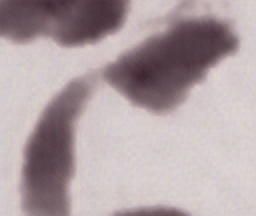

In [ ]:
learn.predict(data_test.x[1])[0]

### Mask Data

In [ ]:
PATH_MASK_X = pathlib.Path('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train_mask/low_res')
PATH_MASK_Y = pathlib.Path('/content/drive/My Drive/Dissertation/Data - Tile 100/20x100x/train_mask/high_res')

In [ ]:
def create_mask_data():
  
    #We apply low_res mask to the high_res images for homogeneity

    low_res = data.dataset.x
    high_res = data.dataset.y
    names = data.dataset.items
    
    for i in tqdm(range(len(data.dataset))):

        mask_low_res = np.array(flip_mask(mask(low_res[i]))) #Needs array, not PIL. WATCH OUT! Can apply flip or not.

        low_res_masked = apply_mask(low_res[i], mask_low_res)
        high_res_masked = apply_mask(high_res[i], mask_low_res)

        low_res_masked.save(PATH_MASK_X/names[i].name)
        high_res_masked.save(PATH_MASK_Y/names[i].name)     

In [ ]:
#create_mask_data()

100%|██████████| 1980/1980 [02:45<00:00, 11.99it/s]


In [ ]:
def learning_combined(img, learner_cell, learner_cyto):

  msk_low_res = single_out_cells(img)
  prediction = learner_cell.predict(msk_low_res)[0] #Get prediction for cell part

  reverse_mask = flip_mask(mask(img)) #Computes flipped mask
  reverse_prediction = learner_cyto.predict(apply_mask(img,np.array(reverse_mask)))[0] #Get prediction for cytoplasm part

  cell_part = convert_Image_RGB(prediction)
  cyto_part = convert_Image_RGB(reverse_prediction)

  return Image(convert_RGB_Image(cell_part + cyto_part))

### Sandbox

In [ ]:
def psnr_test():

  list_values = []

  for i in range(len(data_test.x)):

    prediction = convert_Image_RGB(learning_combined(data_test.x[i],learn_cell, learn_cyto))
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = psnr(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def ssim_test():

  list_values = []

  for i in range(len(data_test.x)):

    prediction = convert_Image_RGB(learning_combined(data_test.x[i],learn_cell, learn_cyto))
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = ssim(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def msssim_test():

  list_values = []

  for i in range(len(data_test.x)):

    prediction = convert_Image_RGB(learning_combined(data_test.x[i],learn_cell, learn_cyto))
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = msssim(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)  

In [ ]:
def vifp_test():

  list_values = []

  for i in range(len(data_test.x)):

    prediction = convert_Image_RGB(learning_combined(data_test.x[i],learn_cell, learn_cyto))
    ground_truth = convert_Image_RGB(data_test.y[i])

    value = vifp(ground_truth,prediction)
    list_values.append(value)

  return sum(list_values) / len(list_values)

In [ ]:
psnr_test()

21.09581539634744

In [ ]:
ssim_test()

0.6649391066617519

In [ ]:
msssim_test()

(0.7981223567727891+0j)

In [ ]:
vifp_test()

0.10202115955383347

### Evaluation